# Cleaning data and the skies

## Executive summary
This notebook explores and cleans the data from the U.S. Environmental Protection Agency (EPA), containing daily ozone measurements at monitoring stations across California.

The major problems with the dataset are datatype mismatches, inconsistencies in the format of the datesaa, and missing values in many columns.

A thorough analysis was performed to clean up the data. Rows with the missing data were dropped, while rows with incomplete data, e.g., missing only the nubmer of the day in some of the dates, were kept to not lose too much data. Data fields were converted to a standardized date format. To draw better insights, columns containing the season and weekday were derived.

The cleaned dataset was used to draw the conclusions and answer research questions. To sum things up, the weekday does not affect the levels of ozone concentration across the region, no areas have consistently a hazardous level of ozone. The ozone concentration varies slightly over time, showing a slight yet stable decrease over the year.

## Imports

In [63]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px  
import folium
from folium.plugins import HeatMap
import nbformat

## Data exploration
First, let's explore the data to see what we are working with.

In [ ]:
ozone_df = pd.read_csv('../data/raw/ozone.csv')
ozone_df.head(10)

Date Source   Site ID  ...   County  Site Latitude Site Longitude
0            /2024    AQS  60010007  ...  Alameda      37.687526    -121.784217
1       01/02/2024    AQS  60010007  ...  Alameda      37.687526    -121.784217
2            /2024    AQS  60010007  ...  Alameda      37.687526    -121.784217
3  January 04/2024    AQS  60010007  ...  Alameda      37.687526    -121.784217
4  January 05/2024    AQS  60010007  ...  Alameda      37.687526    -121.784217
5  January 06/2024    AQS  60010007  ...  Alameda      37.687526    -121.784217
6       01/07/2024    AQS  60010007  ...  Alameda      37.687526    -121.784217
7            /2024    AQS  60010007  ...  Alameda      37.687526    -121.784217
8            /2024    AQS  60010007  ...  Alameda      37.687526    -121.784217
9  January 10/2024    AQS  60010007  ...  Alameda      37.687526    -121.784217

[10 rows x 17 columns]

Let's take a look if there's any data missing.

In [65]:
ozone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54759 entries, 0 to 54758
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  54759 non-null  object 
 1   Source                                54759 non-null  object 
 2   Site ID                               54759 non-null  int64  
 3   POC                                   54759 non-null  int64  
 4   Daily Max 8-hour Ozone Concentration  52021 non-null  float64
 5   Units                                 54759 non-null  object 
 6   Daily AQI Value                       52021 non-null  float64
 7   Local Site Name                       54759 non-null  object 
 8   Daily Obs Count                       54759 non-null  int64  
 9   Percent Complete                      54759 non-null  float64
 10  Method Code                           48269 non-null  float64
 11  CBSA Code      

In [66]:
ozone_df.describe()

Site ID           POC  ...  Site Latitude  Site Longitude
count  5.475900e+04  54759.000000  ...   54759.000000    54759.000000
mean   6.059086e+07      1.000256  ...      36.169550     -119.665107
std    3.001943e+05      0.015988  ...       2.192841        2.022987
min    6.001001e+07      1.000000  ...      32.578165     -124.179490
25%    6.031100e+07      1.000000  ...      34.181977     -121.420838
50%    6.065500e+07      1.000000  ...      36.209286     -119.828400
75%    6.081100e+07      1.000000  ...      37.961578     -118.068500
max    6.113100e+07      2.000000  ...      41.726892     -114.602090

[8 rows x 11 columns]

In [67]:
ozone_df['Units'].unique()

array(['ppm'], dtype=object)

In [68]:
ozone_df['County'].value_counts().sort_index()

County
Alameda            1354
Amador              368
Butte               719
Calaveras           350
Colusa              366
Contra Costa       1105
El Dorado           766
Fresno             2541
Glenn               368
Humboldt            344
Imperial           1204
Inyo               1009
Kern               2878
Kings               363
LA                   37
Lake                360
Los Angeles        4282
Madera              725
Marin               353
Mariposa            585
Mendocino           446
Merced              375
Monterey           1100
Nevada              361
Orange              725
Placer             1814
Riverside          3946
SF                    2
Sacramento         1748
San Benito          721
San Bernardino     3242
San Diego          3227
San Francisco       343
San Joaquin         716
San Luis Obispo    2181
San Mateo           351
Santa Barbara      3198
Santa Clara        1114
Santa Cruz          371
Shasta              976
Siskiyou            371
Solano   

LA and Los Angeles are the same thing, and so are SF and San Francisco. Since LA and SF have a very miniscule amount of records, these will be renamed to Los Angeles and San Francisco respectively.

__Areas to improve:__
- Datatype mismatches: `Site ID` should probably rather be of type integer. Columns `Units`, `Local Site Name`, `CBSA Name`, and `County` should rather be strings, most likely.
- Missing data in: `Daily Max 8-hour Ozone Concentration`, `Method Code`, `CBSA Code`, `CBSA Name`.
- Repeating data in `County` column.
- The dates in `Date` are constantly written in different format. 

Let's take a look at seaborn's `pairplot` to figure out relationships between all possible pairs of columns.

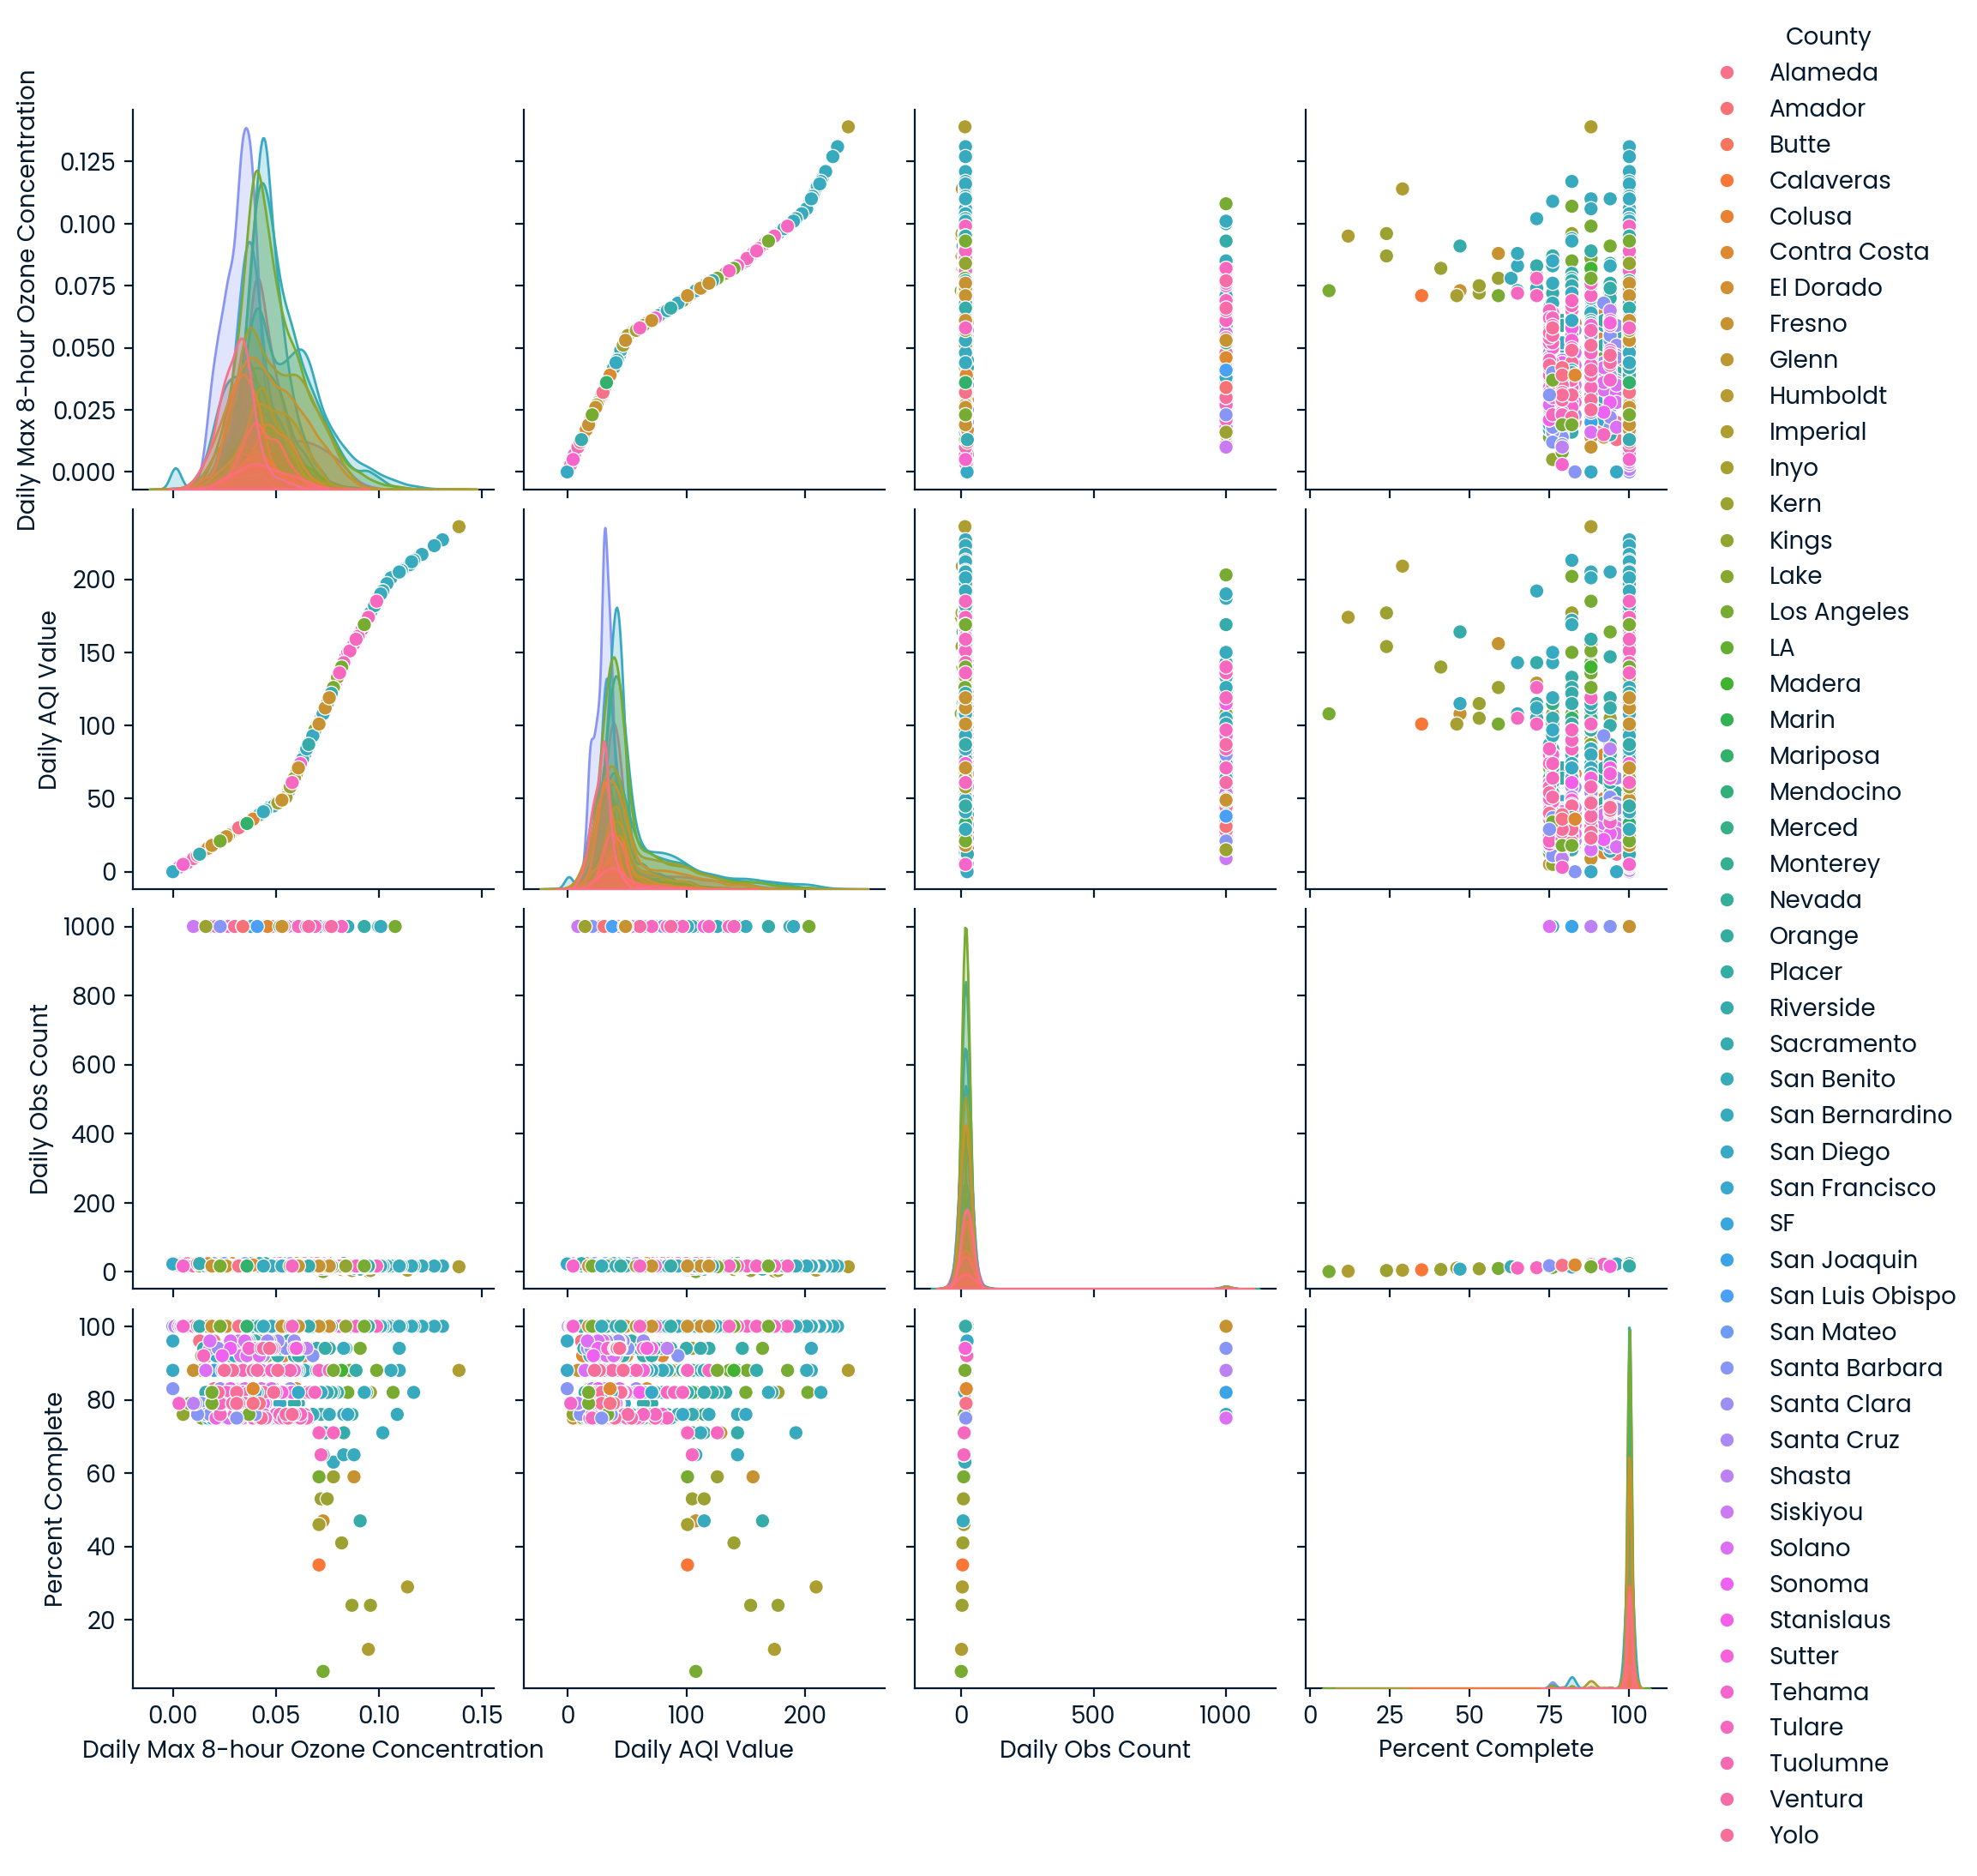

In [69]:
cols_to_plot = ['Daily Max 8-hour Ozone Concentration', 'Daily AQI Value', 'Daily Obs Count', 'Percent Complete', 'County']
sns.pairplot(ozone_df[cols_to_plot],  diag_kind='kde', hue='County')

Obviously, Daily AQI Value and Daily Max 8-hour Ozone Concentration have a clear linear correlation, since AQI is derived from ozone concentration. 
For curiosity, I also wanted to highlight the data by county, but so far it does not provide a lot of valuable insights. 

Let's get straight to data cleaning!

## Data cleaning
I will start with dealing with the duplicates in the `County` column.

In [70]:
ozone_df['County'] = ozone_df['County'].replace({'SF': 'San Francisco', 'LA': 'Los Angeles'})

Moving on to dealing with all the inconsistencies in the `Date` column.  Let's see what period of time does our data spread over.

In [71]:
print(ozone_df['Date'].str.contains('2023').sum())
print(ozone_df['Date'].str.contains('2024').sum())
print(ozone_df['Date'].str.contains('2025').sum())

0
54759
0


As seen before, some of the dates are full, some contain only the year, some contain month (as a word) and a day+year. First, I will deal with dates that contain the month name and day+year only.

In [72]:
ozone_df['Date_parts'] = ozone_df['Date'].astype(str).str.split(' ')
ozone_df['Date_parts']

0                   [/2024]
1              [01/02/2024]
2                   [/2024]
3        [January, 04/2024]
4        [January, 05/2024]
                ...        
54754          [02/16/2024]
54755     [August, 14/2024]
54756       [June, 30/2024]
54757               [/2024]
54758       [July, 22/2024]
Name: Date_parts, Length: 54759, dtype: object

Let's substitute the month name with its respective number and concatenate the proper date.

In [73]:
months = {'01': 'January', 
          '02': 'February', 
          '03': 'March', 
          '04': 'April', 
          '05': 'May', 
          '06': 'June', 
          '07': 'July', 
          '08': 'August', 
          '09': 'September', 
          '10': 'October', 
          '11': 'November', 
          '12': 'December'}

In [74]:
for i, bad_date in enumerate(ozone_df['Date_parts']):
    month_str = bad_date[0]
    if month_str in months.values():
        month_num = [k for k, v in months.items() if v == month_str][0]
        bad_date[0] = month_num
        
    ozone_df.at[i, 'Date_parts'] = '/'.join(bad_date)

In [75]:
print(f'Amount of records with full date: {ozone_df[ozone_df.Date_parts.str.len() == 10].shape[0]}')
print(f'Amount of records NOT with a full date: {ozone_df[ozone_df.Date_parts.str.len() != 10].shape[0]}')

Amount of records with full date: 45557
Amount of records NOT with a full date: 9202


In [76]:
ozone_df['Day'] = None
ozone_df['Month'] = None
ozone_df['Year'] = None

for i, full_date in ozone_df['Date_parts'].items():
    if len(full_date) == 10:
        date_split = full_date.split('/')
        ozone_df.at[i, 'Day'] = date_split[1]
        ozone_df.at[i, 'Month'] = date_split[0]
        ozone_df.at[i, 'Year'] = date_split[2]

In [77]:
ozone_df['Day'].isna().sum()

9202

Moving on to figuring out the weekdays and weekends.

In [78]:
ozone_df['Weekday'] = np.nan 
for i, row in ozone_df.iterrows():
    day = row['Day']
    month = row['Month']
    year = row['Year']

    if pd.notna(day) and pd.notna(month) and pd.notna(year):
        date = pd.to_datetime(f"{year}-{month}-{day}", errors='coerce')

        if pd.isna(date):
            ozone_df.at[i, 'Weekday'] = np.nan
        else:
                ozone_df.at[i, 'Weekday'] = date.weekday() < 5
    else:
        ozone_df.at[i, 'Weekday'] = np.nan

In [79]:
ozone_df.drop(['Date', 'Date_parts'], axis=1, inplace=True)

In [80]:
ozone_df['State'] = None

for i, cbsa_name in ozone_df['CBSA Name'].items():
    if pd.notna(cbsa_name): 
        split_name = cbsa_name.split(', ')
        ozone_df.at[i, 'State'] = split_name[1]

Let's also convert the columns to the correct data types.

In [81]:
ozone_df['Day'] = ozone_df['Day'].astype('Int64') # Int64 instead of regular int because we have NaN values
ozone_df['Month'] = ozone_df['Month'].astype('Int64')
ozone_df['Year'] = ozone_df['Year'].astype('Int64')
ozone_df['Site ID'] = ozone_df['Site ID'].astype('Int64')
ozone_df['Source'] = ozone_df['Source'].astype(str)
ozone_df['Units'] = ozone_df['Units'].astype(str)
ozone_df['Local Site Name'] = ozone_df['Local Site Name'].astype(str)
ozone_df['CBSA Code'] = ozone_df['CBSA Code'].astype('Int64')
ozone_df['County FIPS Code'] = ozone_df['County FIPS Code'].astype('Int64')
ozone_df['County'] = ozone_df['County'].astype(str)
ozone_df['Daily AQI Value'] = ozone_df['Daily AQI Value'].astype('Int64')
ozone_df['POC'] = ozone_df['POC'].astype('Int64')
ozone_df['Method Code'] = ozone_df['Method Code'].astype('Int64')
ozone_df['Percent Complete'] = ozone_df['Percent Complete'].astype('Int64')

Now let's break down the records into seasons. Depending on the month, the season will be set.

In [82]:
ozone_df['Season'] = None

for i, month in ozone_df['Month'].items():
    if pd.notna(month):
        if month in [12, 1, 2]:
            ozone_df.at[i, 'Season'] = 'Winter'
        if month in [3, 4, 5]:
            ozone_df.at[i, 'Season'] = 'Spring'
        if month in [6, 7, 8]:
            ozone_df.at[i, 'Season'] = 'Summer'
        if month in [9, 10, 11]:
            ozone_df.at[i, 'Season'] = 'Autumn'

ozone_df

Source   Site ID  POC  ...  Weekday State  Season
0        AQS  60010007    1  ...      NaN    CA    None
1        AQS  60010007    1  ...     True    CA  Winter
2        AQS  60010007    1  ...      NaN    CA    None
3        AQS  60010007    1  ...     True    CA  Winter
4        AQS  60010007    1  ...     True    CA  Winter
...      ...       ...  ...  ...      ...   ...     ...
54754    AQS  60710005    1  ...     True    CA  Winter
54755    AQS  60270101    1  ...     True    CA  Summer
54756    AQS  60690002    1  ...    False    CA  Summer
54757    AQS  61072010    1  ...      NaN    CA    None
54758    AQS  60611004    1  ...     True    CA  Summer

[54759 rows x 22 columns]

In [83]:
ozone_q1 = ozone_df[
    ozone_df['Daily Max 8-hour Ozone Concentration'].notna() &
    ozone_df['Year'].notna() &
    ozone_df['Month'].notna() & 
    ozone_df['Season'].notna()
]

In [84]:
ozone_q1['Date'] = pd.to_datetime({
    'year': ozone_q1['Year'],
    'month': ozone_q1['Month'],
    'day': ozone_q1['Day']
}, errors='coerce')

In [85]:
ozone_q1

Source   Site ID  POC  ...  State  Season       Date
1        AQS  60010007    1  ...     CA  Winter 2024-01-02
3        AQS  60010007    1  ...     CA  Winter 2024-01-04
4        AQS  60010007    1  ...     CA  Winter 2024-01-05
5        AQS  60010007    1  ...     CA  Winter 2024-01-06
6        AQS  60010007    1  ...     CA  Winter 2024-01-07
...      ...       ...  ...  ...    ...     ...        ...
54751    AQS  60190500    1  ...     CA  Spring 2024-05-20
54752    AQS  60430006    1  ...   None  Summer 2024-08-15
54753    AQS  60371701    1  ...     CA  Autumn 2024-11-27
54754    AQS  60710005    1  ...     CA  Winter 2024-02-16
54755    AQS  60270101    1  ...     CA  Summer 2024-08-14

[43306 rows x 23 columns]

To reduce the noise, I will be calculating rolling average with a 30-day (i.e., approximately 1 month) window size. This can be useful in detecting trend anomalies without focusing on the wrong noise.

In [86]:
ozone_q1 = ozone_q1.sort_values('Date')
ozone_q1.set_index('Date', inplace=True)
daily_avg = ozone_q1.groupby('Date')['Daily Max 8-hour Ozone Concentration'].mean()
print(ozone_q1.head())

           Source   Site ID  POC  ...  Weekday State  Season
Date                              ...                       
2024-01-01    AQS  60953003    1  ...     True    CA  Winter
2024-01-01    AQS  60658005    1  ...     True    CA  Winter
2024-01-01    AQS  60670006    1  ...     True    CA  Winter
2024-01-01    AQS  60714001    1  ...     True    CA  Winter
2024-01-01    AQS  60374009    1  ...     True    CA  Winter

[5 rows x 22 columns]


In [87]:
rolling_avg = daily_avg.rolling(window=30).mean()

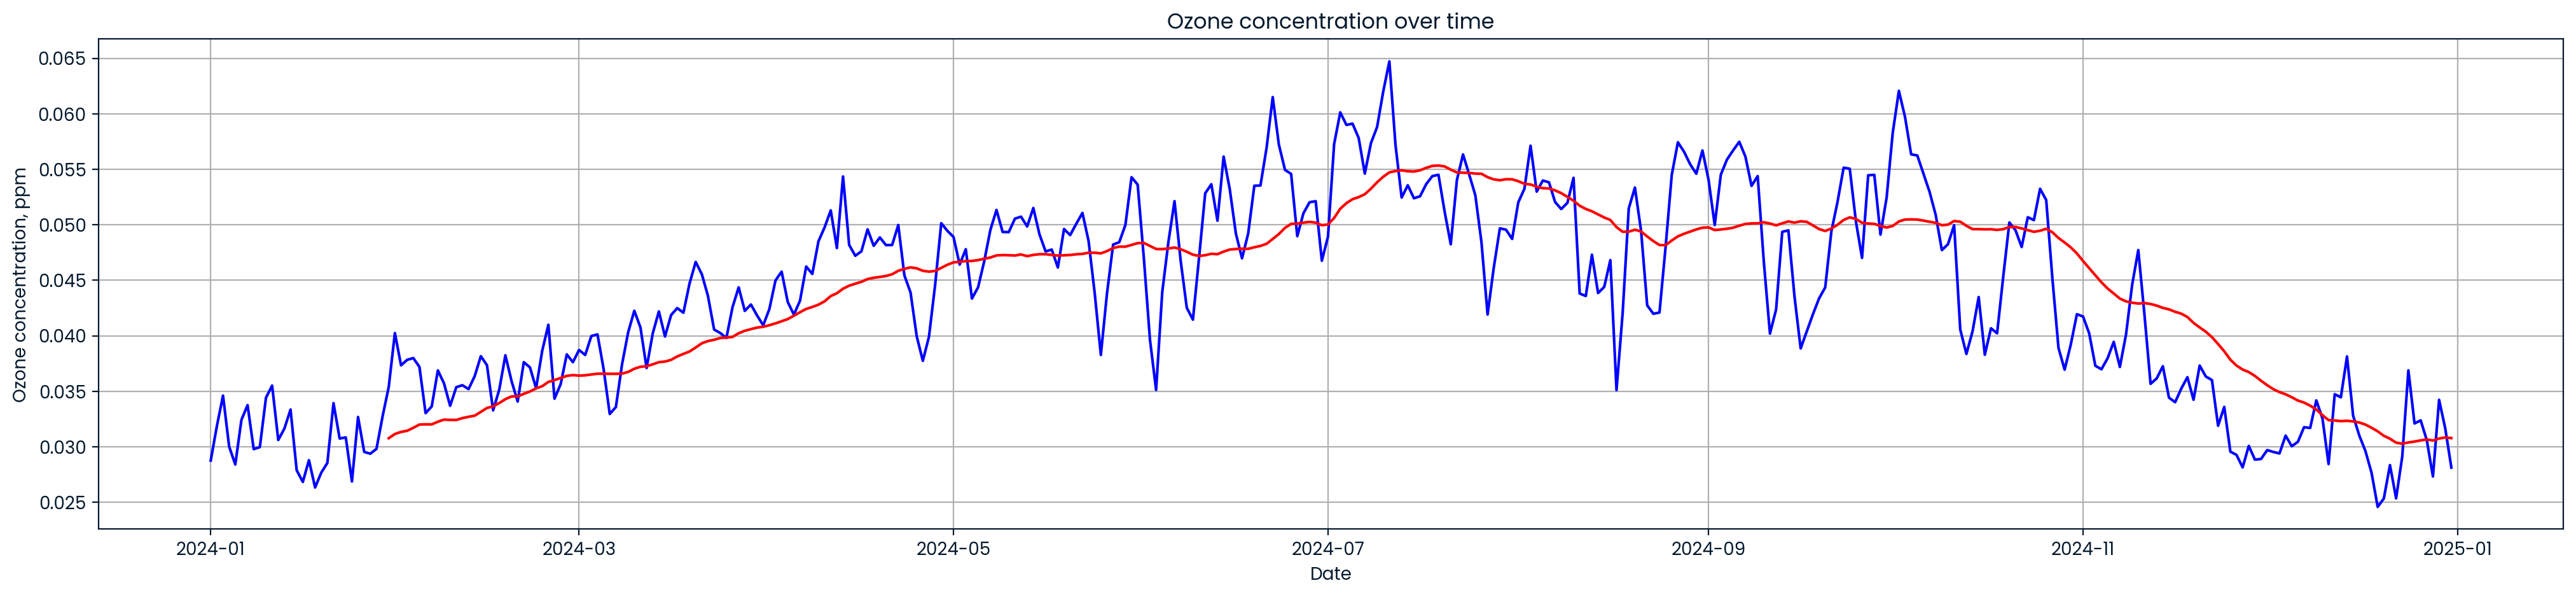

In [88]:
plt.figure(figsize=(25,5))
plt.plot(daily_avg, label='Average daily max 8-hour ozone concentration', color='blue')
plt.plot(rolling_avg, label='Average 30-day max 8-hour ozone concentration', color='red')
plt.title('Ozone concentration over time')
plt.ylabel('Ozone concentration, ppm')
plt.xlabel('Date')
plt.grid(True)
plt.show()

It is clear that there is a visible increase in ozone concentration in the whole region across the time, specifically during summer and first half of the autumn. This could liekly be happening due to the fact that it's the vacation season in the sunny state of California. Let's dvelve a bit deeper and take a look at theh average ozone concentration by county.

### Average ozone concentration by county
Now let's take a look at the average ozone concentration by county. I'd also like to visualise how bad the ozone concentration level is. After a quick Google search, this is what I found:

__Good__: <0.054 ppm

__Moderate__: 0.055-0.070 ppm

__Unhealthy for sensitive individuals__: 0.071-0.085 ppm

__Unhealthy__: 0.086-0.105 ppm 

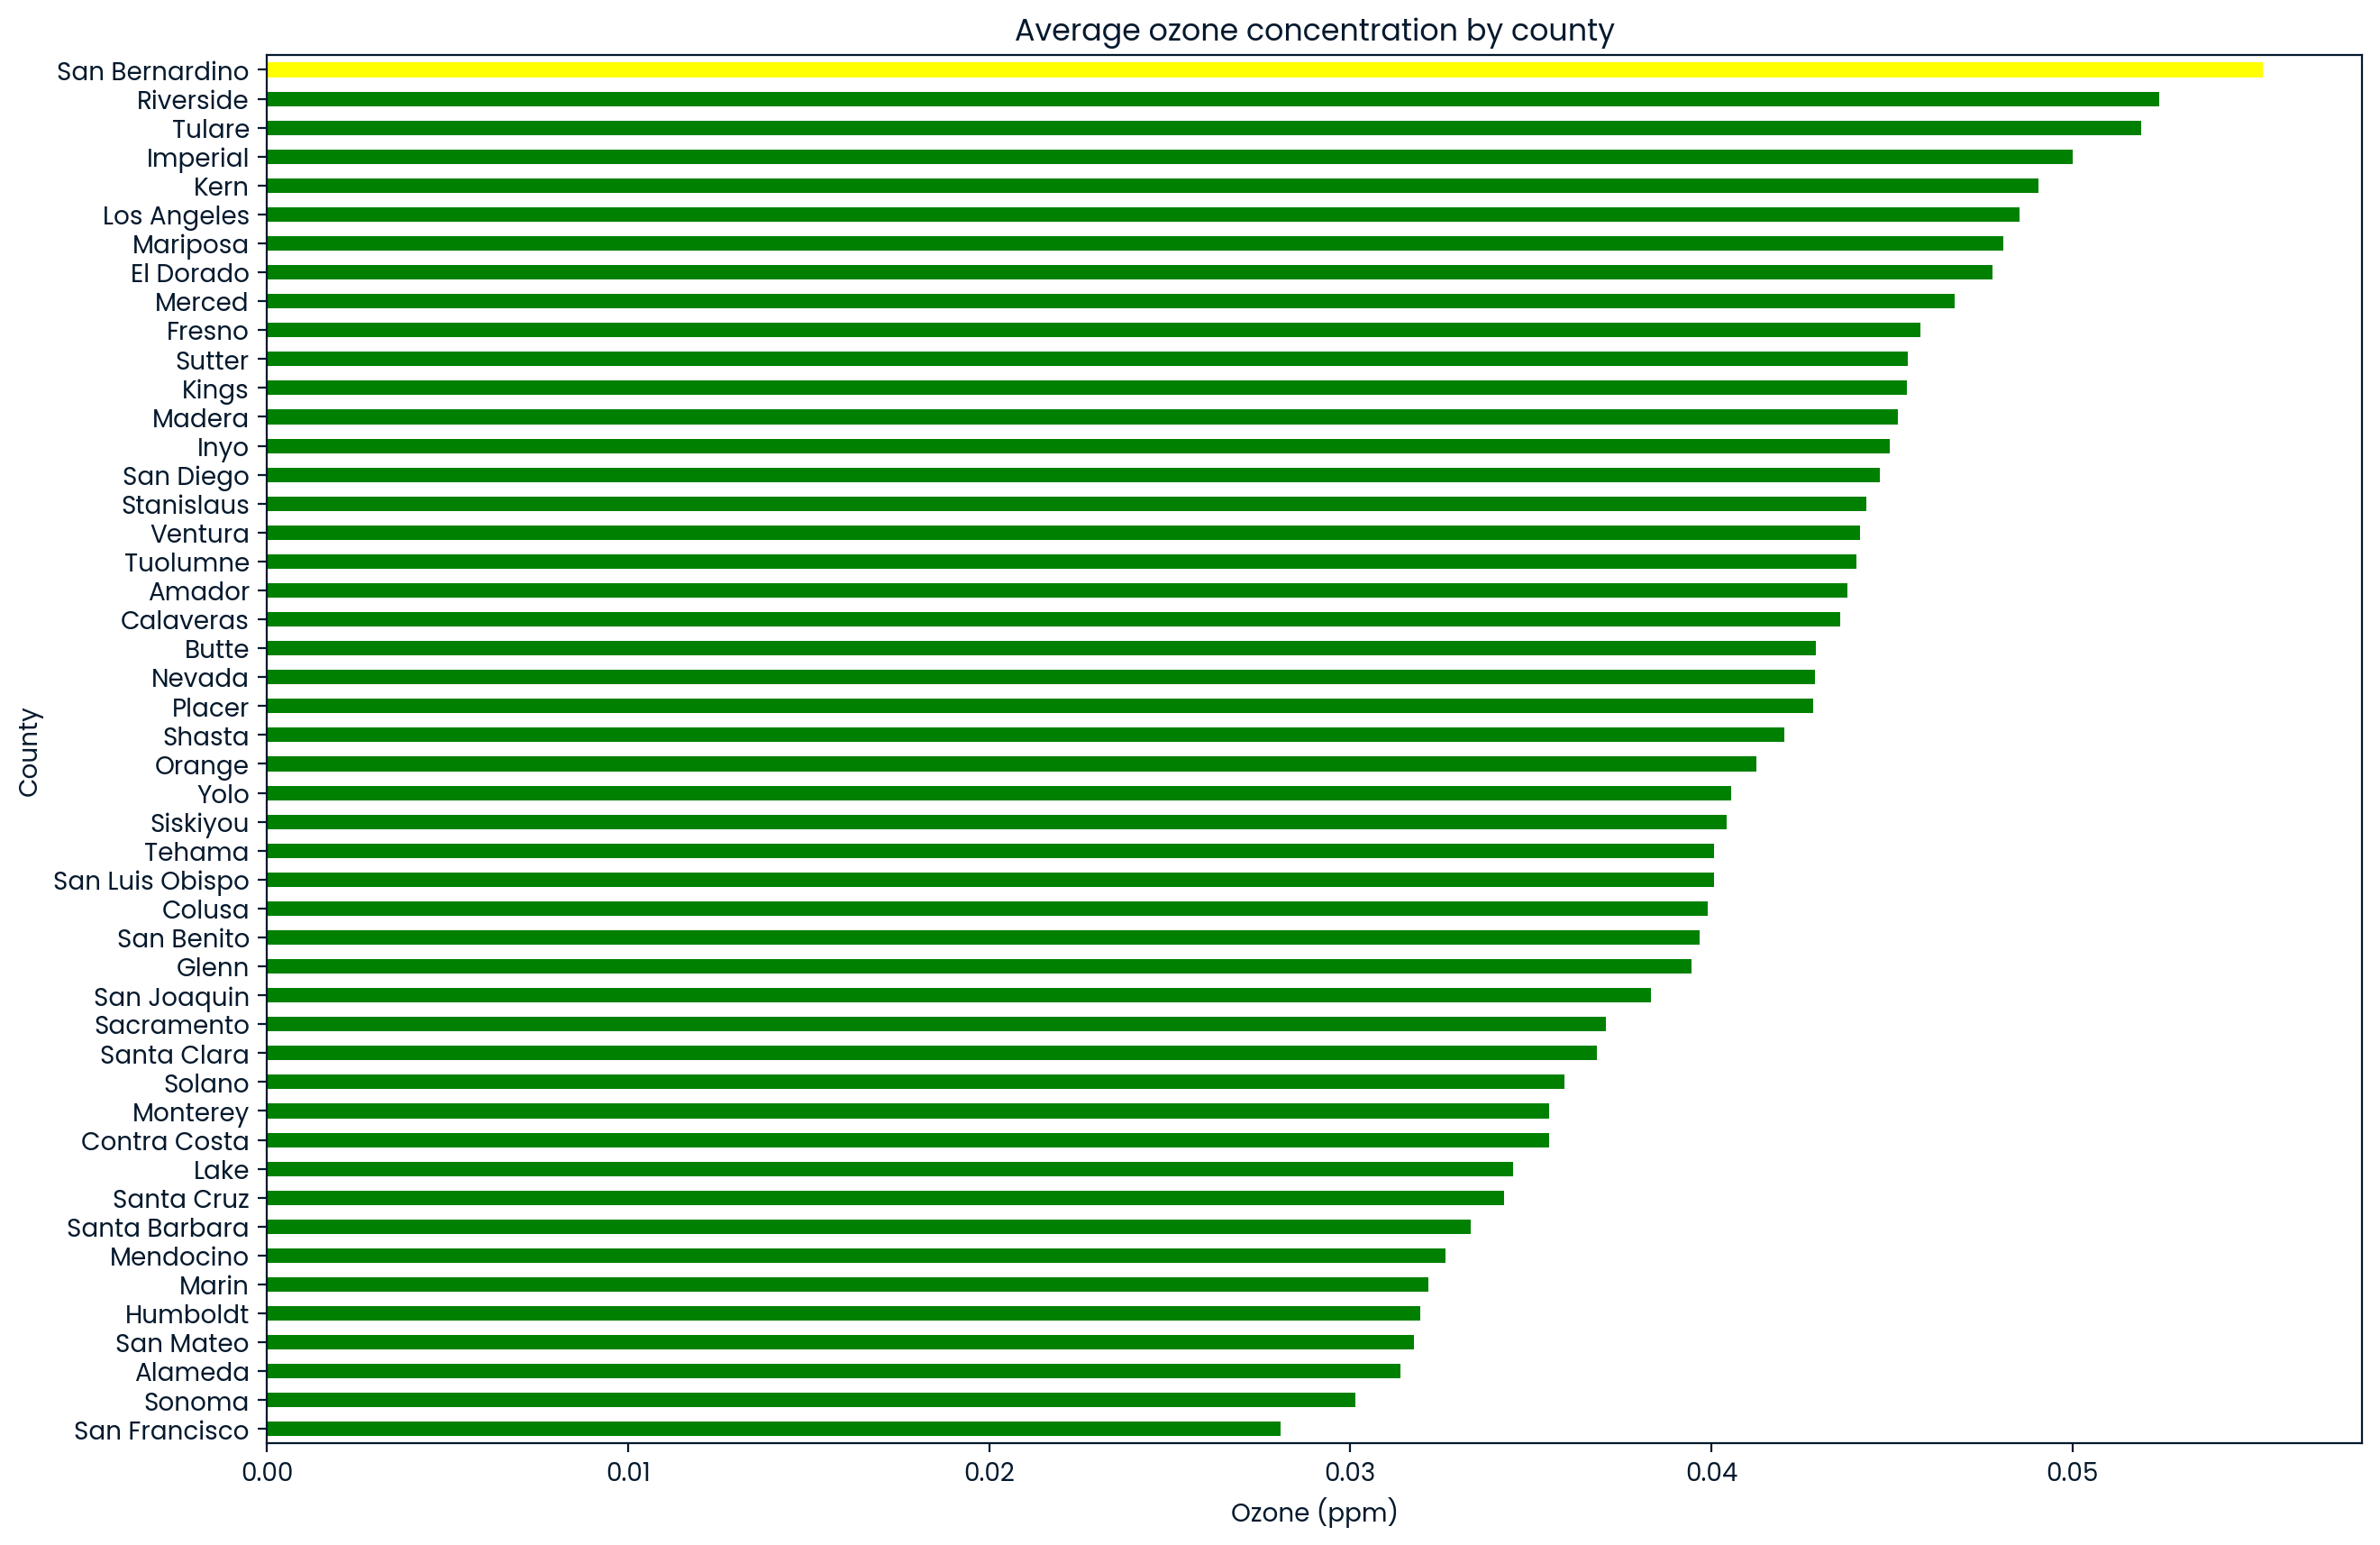

In [89]:
good_threshold = 0.054
moderate_threshold = 0.07
bad_threshold = 0.085
very_bad_threshold = 0.105

county_avg = ozone_q1.groupby('County')['Daily Max 8-hour Ozone Concentration'].mean().sort_values()

colors_thresholds = [
    'green' if ozone_concentration < good_threshold else
    'yellow' if ozone_concentration < moderate_threshold else
    'orange' if ozone_concentration < bad_threshold else
    'red'
    for ozone_concentration in county_avg
]

county_avg.plot(kind='barh', figsize=(15, 10), color=colors_thresholds, title='Average ozone concentration by county')
plt.xlabel('Ozone (ppm)')
plt.show()

In general, the ozone concentrations across the whole region is mostly healthy except for the slight deviation in San Bernardino. Yet, in no county is the ozone concentration dangerous.

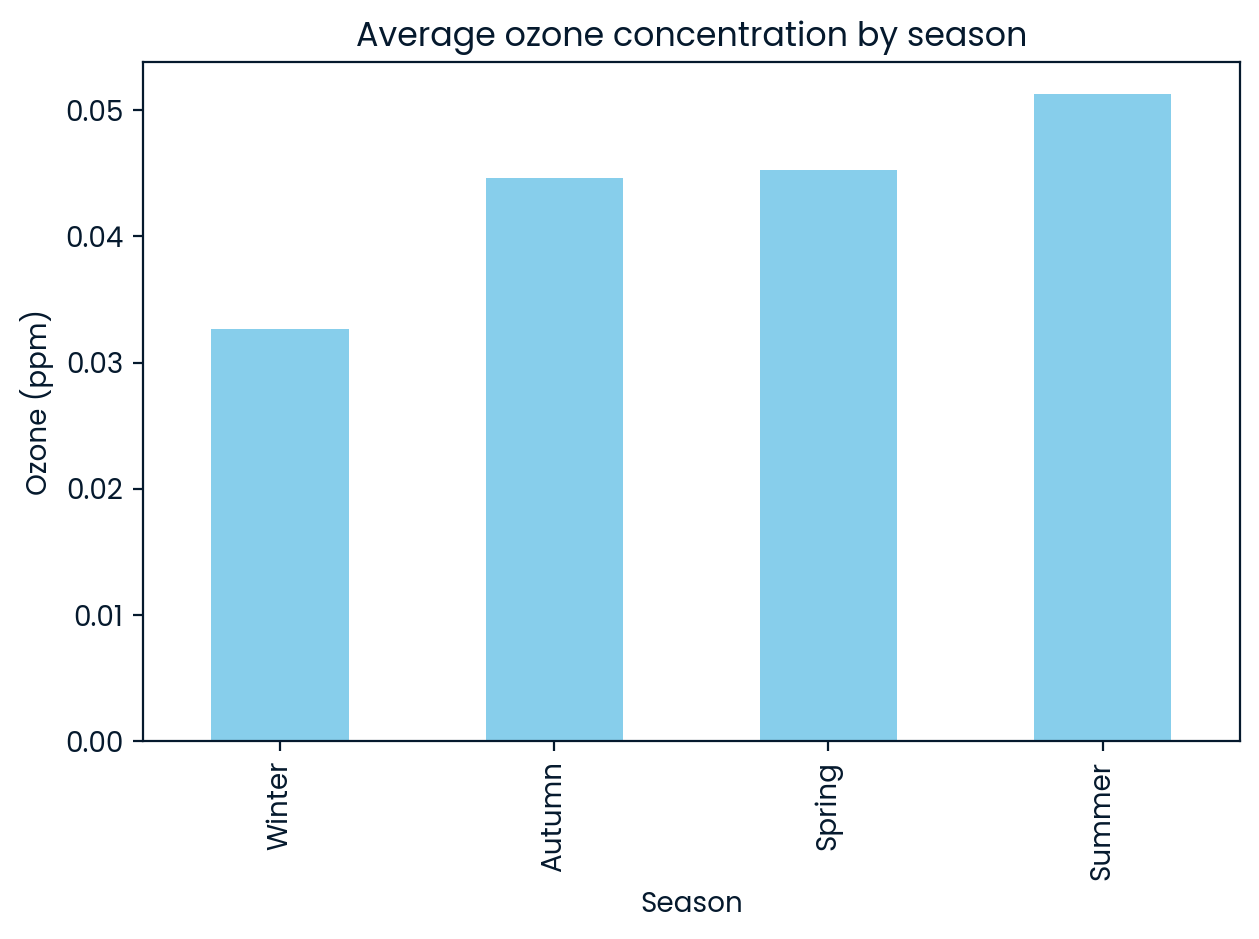

In [90]:
seasonal_avg = ozone_df.groupby('Season')['Daily Max 8-hour Ozone Concentration'].mean().sort_values()
seasonal_avg.plot(kind='bar', color='skyblue', title='Average ozone concentration by season')
plt.ylabel('Ozone (ppm)')
plt.tight_layout()
plt.show()

As remarked earlier, it really does seem that during the peak travel season the ozone concentration is the highest.

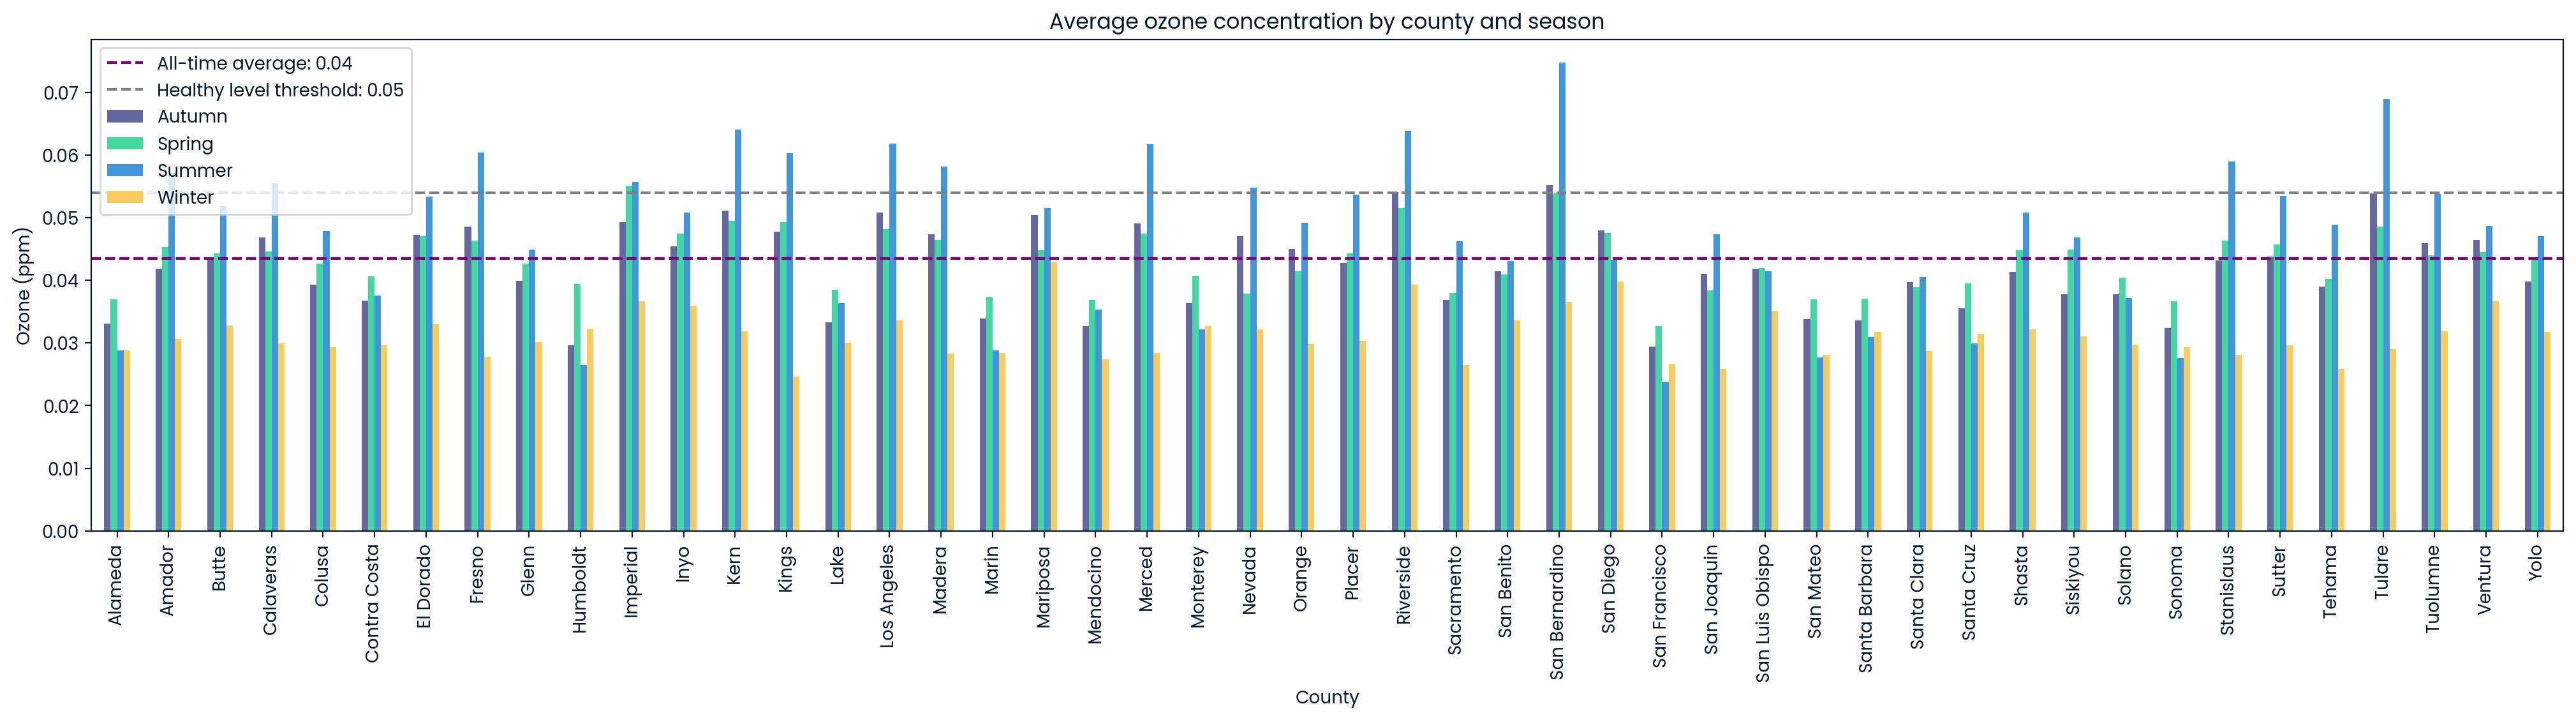

In [95]:
seasonal_county_avg = ozone_df.groupby(['County', 'Season'])['Daily Max 8-hour Ozone Concentration'].mean().unstack()
all_time_avg = ozone_df['Daily Max 8-hour Ozone Concentration'].mean()

seasonal_county_avg.plot(kind='bar', figsize=(25,5))

plt.axhline(all_time_avg, color='purple', linestyle='--', label=f'All-time average: {all_time_avg:.2f}')
plt.axhline(good_threshold, color='grey', linestyle='--', label=f'Healthy level threshold: {good_threshold:.2f}')

plt.title('Average ozone concentration by county and season')
plt.xlabel('County')
plt.ylabel('Ozone (ppm)')
plt.legend()
plt.show()

It is clear that the ozone concentration across the majority of counties is the lowest during winter and the highest during summer, further supporting the hypothesis that this happens due to the fact that summer is the season to travel to California for the vacation. We can also observe that ozone concentration surpasses the healthy level threshold in summer, what is yet again quite logical.

Let's see if the day of the week affects  the ozone concentration levels.

In [92]:
weekday_ozone = ozone_df.groupby('Weekday')['Daily Max 8-hour Ozone Concentration'].mean()
print(weekday_ozone)

Weekday
False    0.043230
True     0.043651
Name: Daily Max 8-hour Ozone Concentration, dtype: float64


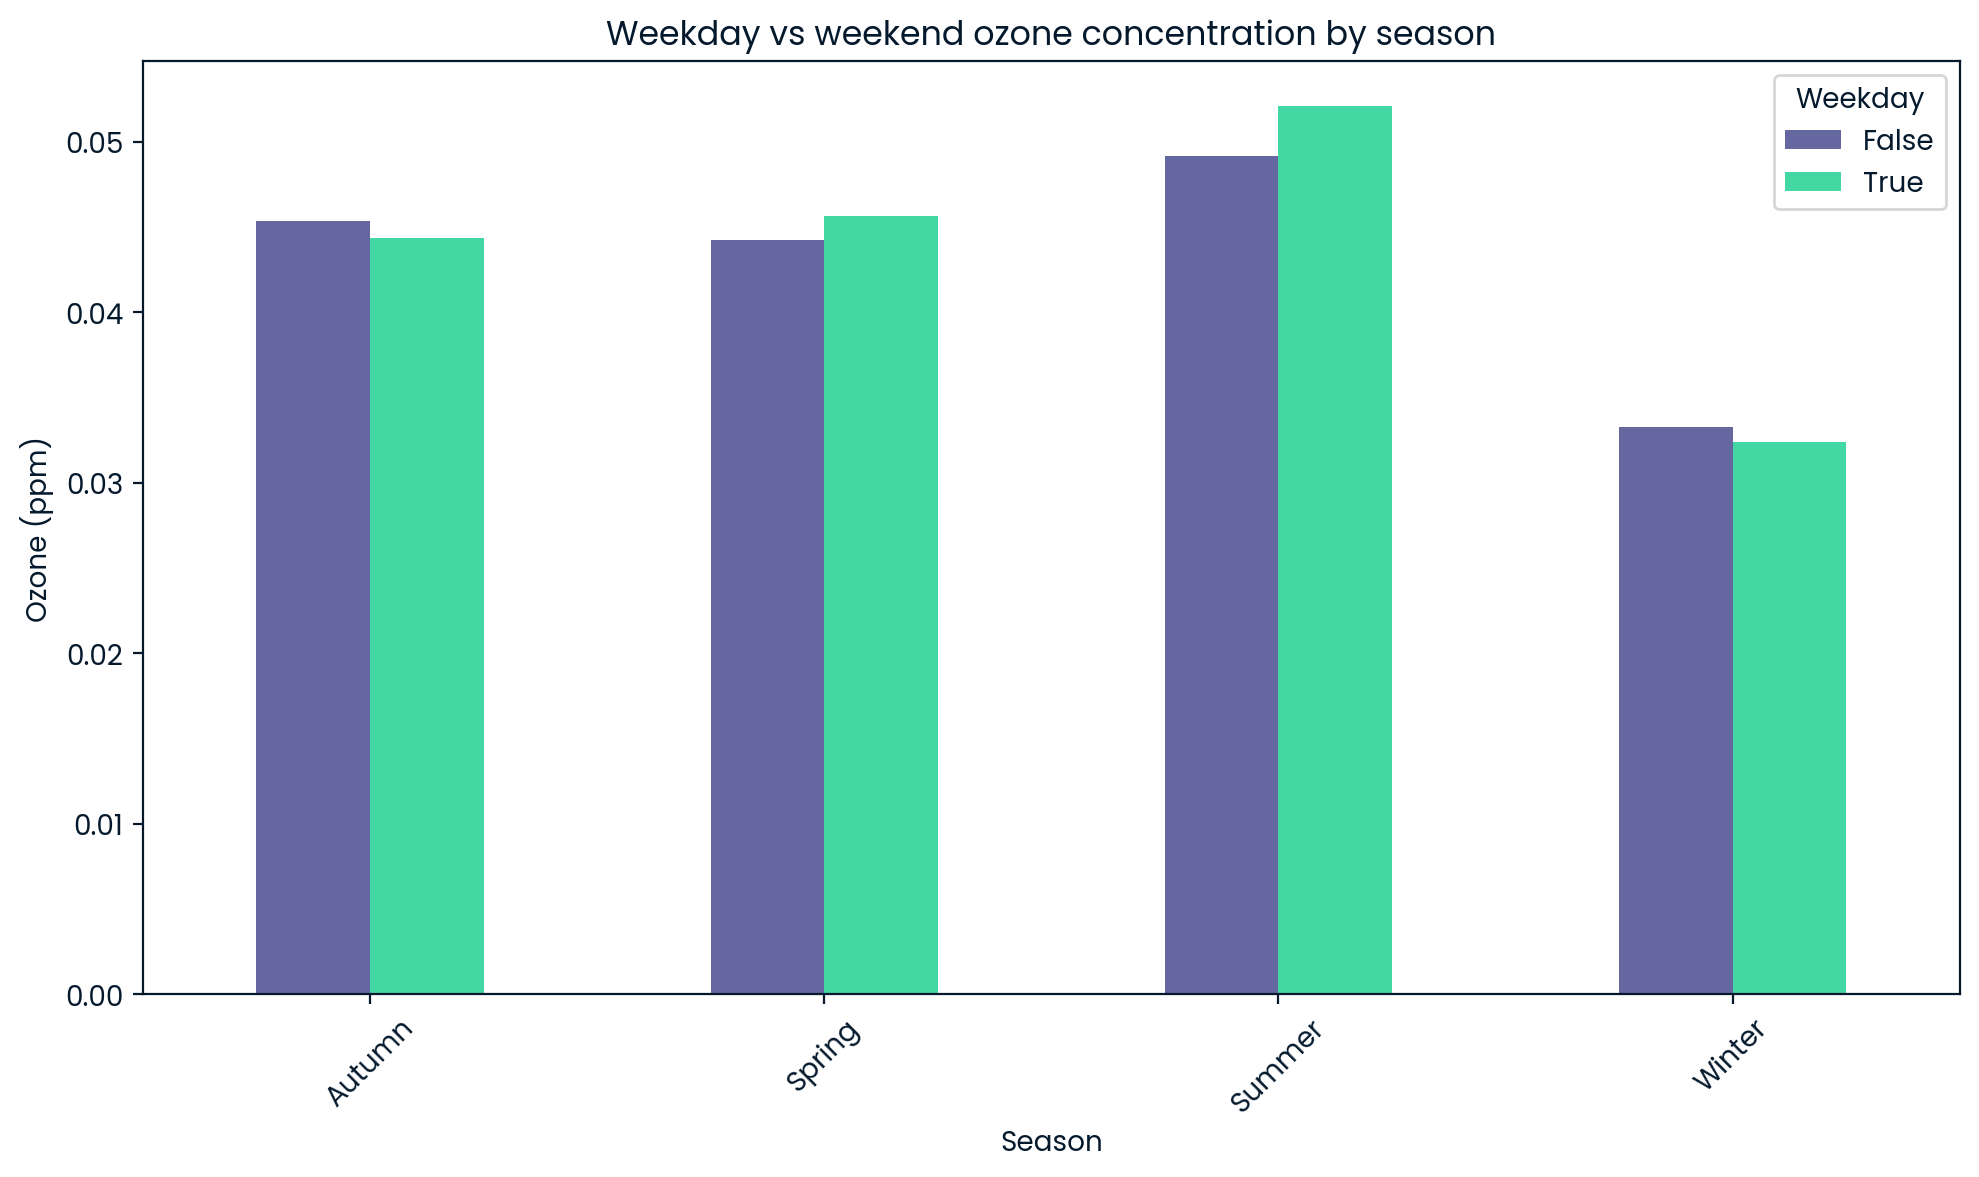

In [93]:
# By weekday and season
weekday_season = ozone_df.groupby(['Season', 'Weekday'])['Daily Max 8-hour Ozone Concentration'].mean().unstack()
weekday_season.plot(kind='bar', figsize=(10, 6))
plt.title('Weekday vs weekend ozone concentration by season')
plt.ylabel('Ozone (ppm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Easy to conclude that in general, the day of the week does not affect the ozone concentration levels.

Let's now plot the ozone concentration levels on the map to get a better visualisation of the region.

In [94]:
ozone_df_nonan = ozone_df.dropna(subset=['Site Latitude', 'Site Longitude', 'Daily Max 8-hour Ozone Concentration'])
agg_df = ozone_df_nonan.groupby(['Site Latitude', 'Site Longitude'], as_index=False)['Daily Max 8-hour Ozone Concentration'].mean()

map_fig = px.density_mapbox(agg_df, 
                            lat='Site Latitude', 
                            lon='Site Longitude', 
                            z='Daily Max 8-hour Ozone Concentration',
                            radius=20,
                            center=dict(lat=37, lon=-119),
                            zoom=4,

                            mapbox_style="open-street-map")
map_fig.show()

## Summary
Key cleaning steps included removing rows with missing data, standardizing location and date fields, expanding on the dates (adding weekdays and seasons), and aggregating ozone readings by site and date. A rolling average was also applied to smooth daily fluctuations and focus on evident trends.

Exploratory analysis revealed that ozone levels tend to exceed healthy thresholds during summer. A seasonal bar chart highlighted these trends across regions and a map with the ozone concentration was visualised for a better understanding.

The dataset is now ready for deeper analysis or forecasting.